# Checking AngSep calculated by fGetNearestObjEq

Query: 

select 
   s.MAG_AUTO, s.MAGERR_AUTO, 
   
   ...
   
   nb.distance*60 into mydb.HST_PS1_mean from MyDB.HST_COSMOS s

cross apply fGetNearestObjEq(s.ALPHA_J2000, s.DELTA_J2000, 0.5/60.0) nb

inner join ObjectThin o on o.objid=nb.objid and o.nDetections>1

inner join MeanObject m on o.objid=m.objid and o.uniquePspsOBid=m.uniquePspsOBid

In [67]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
%matplotlib inline
hst_ps1_mean = pd.read_csv('HST_PS1_mean_tachibana.csv')
hst_ps1_stack = pd.read_csv('HST_PS1_stack_tachibana.csv')

In [68]:
cat_mean = hst_ps1_mean.drop_duplicates(['objID'])
cat_stack = hst_ps1_stack.drop_duplicates(['objID'])
cat = pd.merge(cat_mean, cat_stack, on='objID', how='outer')

In [69]:
del hst_ps1_mean, hst_ps1_stack, cat_mean, cat_stack

angsep: https://github.com/kasperschmidt/python/blob/master/code_others/angsep.py

In [70]:
from numpy import *
import string
import sys

def angsep(ra1deg,dec1deg,ra2deg,dec2deg):
    ra1rad=ra1deg*pi/180
    dec1rad=dec1deg*pi/180
    ra2rad=ra2deg*pi/180
    dec2rad=dec2deg*pi/180
    
    x=cos(ra1rad)*cos(dec1rad)*cos(ra2rad)*cos(dec2rad)
    y=sin(ra1rad)*cos(dec1rad)*sin(ra2rad)*cos(dec2rad)
    z=sin(dec1rad)*sin(dec2rad)
    
    rad=arccos(x+y+z)

    sep = choose( rad<0.000004848 , (
        sqrt((cos(dec1rad)*(ra1rad-ra2rad))**2+(dec1rad-dec2rad)**2),rad))
    
    sep=sep*180/pi

    return sep*3600

In [71]:
det_stack = cat.raStack_x!=-999
AngSepMean = angsep(cat.ALPHA_J2000[det_stack], cat.DELTA_J2000[det_stack], 
                   cat.raMean[det_stack], cat.decMean[det_stack])
AngSepStack = angsep(cat.ALPHA_J2000[det_stack], cat.DELTA_J2000[det_stack], 
                   cat.raStack_x[det_stack], cat.decStack_x[det_stack])
AngSep = cat.Column1_x[det_stack]

#### AngSepMean: angsep(ALPHA_J2000, DELTA_J200, raMean, decMean)
#### AngSepStack: angsep(ALPHA_J2000, DELTA_J200, raStack, decStack)
#### AngSep: fGetNearestObjEq(ALPHA_J2000, DELTA_J200, 0.5/60.0)

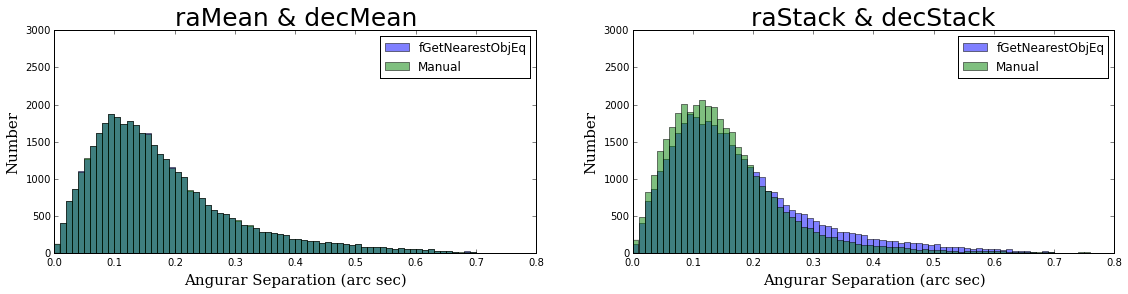

In [72]:
plt.figure(figsize=(19,4))
plt.subplot(1,2,1)
plt.hist(AngSep, bins=np.arange(0,1,0.01), alpha=0.5, label='fGetNearestObjEq')
plt.hist(AngSepMean, bins=np.arange(0,1,0.01), alpha=0.5, label='Manual')
plt.xlim(0,0.8);plt.ylim(0,3000)
plt.title('raMean & decMean', fontsize=25)
plt.xlabel("Angurar Separation (arc sec)" , fontname='serif', fontsize=15)
plt.ylabel("Number" , fontname='serif', fontsize=15)
plt.legend(loc='upper right')
plt.subplot(1,2,2)
plt.hist(AngSep, bins=np.arange(0,1,0.01), alpha=0.5, label='fGetNearestObjEq')
plt.hist(AngSepStack, bins=np.arange(0,1,0.01), alpha=0.5, label='Manual')
plt.xlim(0,0.8);plt.ylim(0,3000)
plt.title('raStack & decStack',  fontsize=25)
plt.xlabel("Angurar Separation (arc sec)" , fontname='serif', fontsize=15)
plt.ylabel("Number" , fontname='serif', fontsize=15)
plt.legend(loc='upper right')
plt.show()

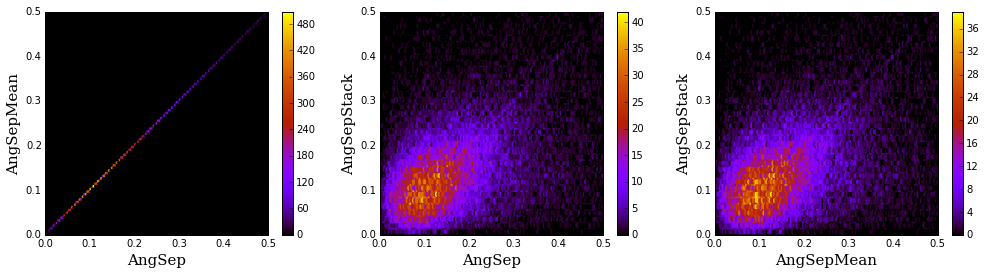

In [73]:
plt.figure(figsize=(17,4))
plt.subplot(1,3,1)
plt.hexbin(AngSep, AngSepMean, cmap='gnuplot', gridsize=250)
plt.xlim(0,0.5);plt.ylim(0,0.5)
plt.xlabel("AngSep", fontname='serif', fontsize=15)
plt.ylabel("AngSepMean", fontname='serif', fontsize=15)
plt.colorbar()
plt.subplot(1,3,2)
plt.hexbin(AngSep, AngSepStack, cmap='gnuplot', gridsize=250)
plt.xlim(0,0.5);plt.ylim(0,0.5)
plt.xlabel("AngSep", fontname='serif', fontsize=15)
plt.ylabel("AngSepStack", fontname='serif', fontsize=15)
plt.colorbar()
plt.subplot(1,3,3)
plt.hexbin(AngSepMean, AngSepStack, cmap='gnuplot', gridsize=250)
plt.xlim(0,0.5);plt.ylim(0,0.5)
plt.xlabel("AngSepMean", fontname='serif', fontsize=15)
plt.ylabel("AngSepStack", fontname='serif', fontsize=15)
plt.colorbar()
plt.show();plt.close()

Angular separation returned by fGetNearestObjEq() is calculated based on raMean and decMean. 

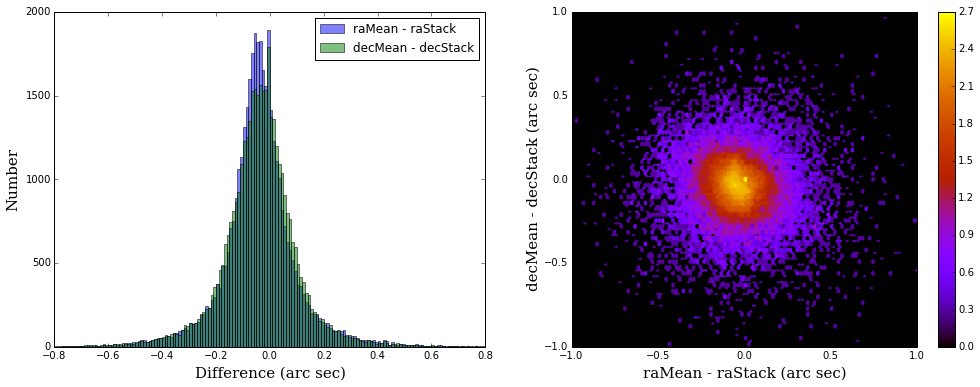

In [74]:
plt.figure(figsize=(17,6))
plt.subplot(1,2,1)
plt.hist((cat.raMean[det_stack] - cat.raStack_x[det_stack])*3600, bins=np.arange(-1,1,0.01), alpha=0.5, label='raMean - raStack')
plt.hist((cat.decMean[det_stack] - cat.decStack_x[det_stack])*3600, bins=np.arange(-1,1,0.01), alpha=0.5, label='decMean - decStack')
plt.xlim(-0.8 ,0.8);plt.ylim(0,2000)
plt.xlabel("Difference (arc sec)" , fontname='serif', fontsize=15)
plt.ylabel("Number" , fontname='serif', fontsize=15)
plt.legend(loc='upper right')
plt.subplot(1,2,2)
plt.hexbin((cat.raMean[det_stack] - cat.raStack_x[det_stack])*3600, 
           (cat.decMean[det_stack] - cat.decStack_x[det_stack])*3600, 
           extent=[-1,1,-1,1], bins='log', cmap='gnuplot', gridsize=100)
plt.colorbar()
plt.xlim(-1,1);plt.ylim(-1,1)
plt.xlabel("raMean - raStack (arc sec)" , fontname='serif', fontsize=15)
plt.ylabel("decMean - decStack (arc sec)" , fontname='serif', fontsize=15)
plt.show()

In [75]:
mean_dra = np.mean( (cat.raMean[det_stack] - cat.raStack_x[det_stack])*3600 )
mean_ddec = np.mean( (cat.decMean[det_stack] - cat.decStack_x[det_stack])*3600 )
sigma_dra = np.sqrt(np.var( (cat.raMean[det_stack] - cat.raStack_x[det_stack])*3600 ))
sigma_ddec = np.sqrt(np.var( (cat.decMean[det_stack] - cat.decStack_x[det_stack])*3600 ))
print 'Mean of [raMean - raStack] is %.3f arcsec' %mean_dra
print 'Mean of [decMean - decStack] is %.3f arcsec' %mean_ddec
print 'Standard dviation of [raMean - raStack] is %.3f arcsec' %sigma_dra
print 'Standard dviation of [decMean - decStack] is %.3f arcsec' %sigma_ddec

Mean of [raMean - raStack] is -0.039 arcsec
Mean of [decMean - decStack] is -0.038 arcsec
Standard dviation of [raMean - raStack] is 0.145 arcsec
Standard dviation of [decMean - decStack] is 0.146 arcsec
